Hunter Bennett | Glass Lab | Kupffer Strains Project | 4 June 2021

This is a re-vamp of the differential peak calling pipeline for comparisons within strains in a given condition (healthy, CCl4, NASH). This pipeline takes in ATAC-seq peaks annotated with H3K27Ac ChIP-seq data (or other histone modified data) from three strains (c57, balb, and aj) and compares each strain to the other pairwise. The main outputs of this file are:
1. A homer differential peak file containing each pairwise comparison.
2. Scatterplots of each pairwise comparison with significant peaks highlighted.
3. Heatmaps of differential peaks across all comparisons to highlight patterns.
4. Peak files for GREAT analysis of functional annotations associated with genomic regions.

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
controlDirectory = '/home/h1bennet/strains/data/ATAC/control_f1/'
workingDirectory = '/home/h1bennet/strains_f1/results/00_CB6F1_Control/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


### Read in raw gene expression files

In [3]:
df, mat = read_annotated_peaks('./peakQuan/allRawTags.txt')

In [4]:
best_reps = ['/home/h1bennet/strains/data/H3K27Ac/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61A_TDT_l20201212_AGTTCAGG_CCAACAGA_S23_L001.mm10.bowtie2.sam',
       '/home/h1bennet/strains/data/H3K27Ac/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61BC_TDT_l20201212_GACCTGAA_TTGGTGAG_S24_L001.mm10.bowtie2.sam',
       '/home/h1bennet/strains/data/H3K27Ac/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61D_TDT_l20201212_TCTCTACT_CGCGGTTC_S25_L001.mm10.bowtie2.sam',
       '/home/h1bennet/strains/data/H3K27Ac/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61A_TDT_l20201212_AGTTCAGG_CCAACAGA_S23_L001.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/H3K27Ac/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61BC_TDT_l20201212_GACCTGAA_TTGGTGAG_S24_L001.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/H3K27Ac/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61D_TDT_l20201212_TCTCTACT_CGCGGTTC_S25_L001.balbcj.bowtie2_shifted_from_BALBCJ.sam']

In [5]:
# import annotation file
df, mat = read_annotated_peaks('./peakQuan/allRawTags.txt')

# pull out selected samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df= df.loc[:, tst]
mat = mat.loc[:, mat.columns.str.contains('|'.join(best_reps))]

df.to_csv('./peakQuan/allRawTags_onlymuts.txt', sep='\t')


# also save version that filters based on amounts of tags
groups = [[0,1,2],
         [3,4,5]]
thresh = 4
n_passing_thresh=2

peaks = []
for group in groups:
    bool_peaks = (mat.iloc[:, group] > thresh).sum(1)>n_passing_thresh
    peaks.extend(mat.index[bool_peaks])
                  
mat_filt = mat.reindex(set(peaks)).dropna()
df_filt = df.reindex(set(peaks)).dropna()

print("N IDR Peaks:", mat.shape[0])
print("N Peaks Passing Thresh:", len(set(peaks)))
print("N Filtered Peaks:", mat_filt.shape[0])

df_filt.to_csv('./peakQuan/allRawTags_onlymuts_filtered_peaks.txt', sep='\t')

N IDR Peaks: 137971
N Peaks Passing Thresh: 22655
N Filtered Peaks: 22655


### Run Differential Peaks for All Samples

In [6]:
# %%bash

# source activate deseq_36
# getDiffExpression.pl ./peakQuan/allRawTags_onlymuts.txt \
# 00_cb6f1_c57 00_cb6f1_c57 00_cb6f1_c57 \
# 01_cb6f1_balb 01_cb6f1_balb 01_cb6f1_balb \
# -peaks > ./diff_output.txt


In [7]:
# %%bash

# source activate deseq_36
# getDiffExpression.pl ./peakQuan/allRawTags_onlymuts_filtered_peaks.txt \
# 00_cb6f1_c57 00_cb6f1_c57 00_cb6f1_c57 \
# 01_cb6f1_balb 01_cb6f1_balb 01_cb6f1_balb \
# -peaks > ./diff_output_filtered_peaks.txt

# Scatter plot of differentially acetylated enhancers

In [8]:
log2fc = np.log2(2)
pval = 0.05

## Unfiltered peaks...

In [9]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_output.txt',
    './peakQuan/allRawTags_onlymuts.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (137971, 24)
getDiffExpression selected transcripts (137971, 27)
annotatePeaks selected peaks (137971, 24)


dict_keys(['00_cb6f1_c57 vs. 01_cb6f1_balb'])

In [10]:
comps = ['00_cb6f1_c57 vs. 01_cb6f1_balb']

groups = [[[0,1,2],[3,4,5]]]

cols = []
for i in groups:
    for j in i:
        cols.extend(j)
cols = [cols]

colors = [['#3182bd', '#31a354']]

00_cb6f1_c57 vs. 01_cb6f1_balb
N peaks downregulated 1204
N peaks upregulated 945



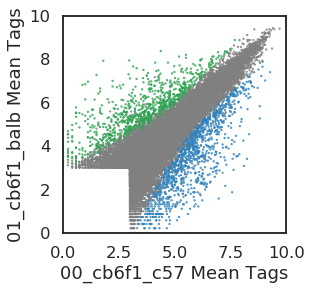

In [11]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    de = de.reindex(de.index[(de.g0_mean >= 3) | (de.g1_mean >= 3)])

    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -log2fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > log2fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -log2fc)))
    print('N peaks upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > log2fc)))
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

# Filtered peaks

In [12]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_output_filtered_peaks.txt',
    './peakQuan/allRawTags_onlymuts_filtered_peaks.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (21281, 24)
getDiffExpression selected transcripts (21281, 27)
annotatePeaks selected peaks (21281, 24)


dict_keys(['00_cb6f1_c57 vs. 01_cb6f1_balb'])

In [13]:
comps = ['00_cb6f1_c57 vs. 01_cb6f1_balb']

groups = [[[0,1,2],[3,4,5]]]

cols = []
for i in groups:
    for j in i:
        cols.extend(j)
cols = [cols]

colors = [['#3182bd', '#31a354']]

00_cb6f1_c57 vs. 01_cb6f1_balb
N peaks downregulated 1010
N peaks upregulated 758



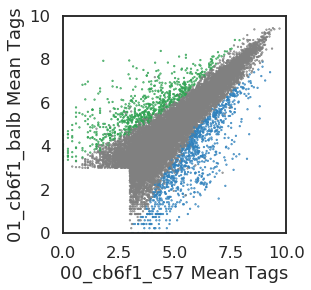

In [14]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    de = de.reindex(de.index[(de.g0_mean >= 3) | (de.g1_mean >= 3)])

    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -log2fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > log2fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -log2fc)))
    print('N peaks upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > log2fc)))
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

# Check Quality of Differential Calls

We will do this first by looking at overlap with some of the plots we have made previously...

In [15]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_output_filtered_peaks.txt',
    './peakQuan/allRawTags_onlymuts_filtered_peaks.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (21281, 24)
getDiffExpression selected transcripts (21281, 27)
annotatePeaks selected peaks (21281, 24)


dict_keys(['00_cb6f1_c57 vs. 01_cb6f1_balb'])

In [16]:
df = pd.read_csv('./peaks_with_asb_min_tag_filter.txt',
                 sep='\t',
                 index_col=0)

In [17]:
df['adj_pval'] = diff_peak['00_cb6f1_c57 vs. 01_cb6f1_balb adj. p-value']
color= ['#de2d26' if i < 0.05 else '#bdbdbd' for i in df['adj_pval']]

Text(0, 0.5, 'Allelic Bias Mean TPM Second')

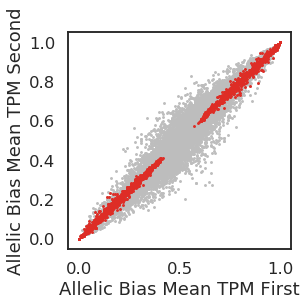

In [18]:
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(df['allelic_bias_only_muts'],
           df['allelic_bias_only_muts_mean_second'],
           c='#bdbdbd',
           s=2)

ax.scatter(df.loc[df.adj_pval < 0.05, 'allelic_bias_only_muts'],
           df.loc[df.adj_pval < 0.05, 'allelic_bias_only_muts_mean_second'],
           c='#de2d26',
           s=2)

ax.set_xlabel('Allelic Bias Mean TPM First')
ax.set_ylabel('Allelic Bias Mean TPM Second')

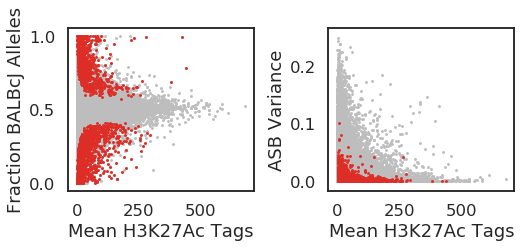

In [19]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
plt.subplots_adjust(wspace=0.4)

axs[0].scatter(df.loc[:, ['c57bl6j_tag_perfect', 'balbcj_tag_perfect']].mean(1),
               df.loc[:, 'mean_second_asb_mean'],
               c='#bdbdbd',
               s=2)

axs[0].scatter(df.loc[df.adj_pval < 0.05, ['c57bl6j_tag_perfect', 'balbcj_tag_perfect']].mean(1),
               df.loc[df.adj_pval < 0.05, 'mean_second_asb_mean'],
               c='#de2d26',
               s=2)

axs[0].set_ylabel('Fraction BALBcJ Alleles')
axs[0].set_xlabel('Mean H3K27Ac Tags');

axs[1].scatter(df.loc[:, ['c57bl6j_tag_perfect', 'balbcj_tag_perfect']].mean(1),
               df.loc[:, 'mean_second_asb_var'],
               c='#bdbdbd',
               s=2)

axs[1].scatter(df.loc[df.adj_pval < 0.05, ['c57bl6j_tag_perfect', 'balbcj_tag_perfect']].mean(1),
               df.loc[df.adj_pval < 0.05, 'mean_second_asb_var'],
               c='#de2d26',
               s=2)

axs[1].set_ylabel('ASB Variance')
axs[1].set_xlabel('Mean H3K27Ac Tags');

# Visual inspection of differential regions...

In [20]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

diff_peak.to_csv('./diff_output_filtered_peaks_with_location.txt',
                 sep='\t')

In [101]:
diff_peak.columns

Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Distance to TSS', 'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene',
       'Nearest Refseq', 'Nearest Ensembl', 'Gene Name', 'Gene Alias',
       'Gene Description', 'Gene Type',
       '/home/h1bennet/strains/data/H3K27Ac/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61A_TDT_l20201212_AGTTCAGG_CCAACAGA_S23_L001.mm10.bowtie2.sam',
       '/home/h1bennet/strains/data/H3K27Ac/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61BC_TDT_l20201212_GACCTGAA_TTGGTGAG_S24_L001.mm10.bowtie2.sam',
       '/home/h1bennet/strains/data/H3K27Ac/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61D_TDT_l20201212_TCTCTACT_CGCGGTTC_S25_L001.mm10.bowtie2.sam',
       '/home/h1bennet/strains/data/H3K27Ac/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Ch

In [102]:
viz_cols = ['Annotation', 'Distance to TSS', 'Gene Name', 'location', 'Annotation',
            '00_cb6f1_c57 vs. 01_cb6f1_balb Log2 Fold Change','00_cb6f1_c57 vs. 01_cb6f1_balb adj. p-value']
diff_peak_viz = diff_peak.loc[:, viz_cols]

In [104]:
diff_peak_viz.sort_values(
    '00_cb6f1_c57 vs. 01_cb6f1_balb adj. p-value', ascending=True).head(50)

,Annotation,Distance to TSS,Gene Name,location,Annotation,00_cb6f1_c57 vs. 01_cb6f1_balb Log2 Fold Change,00_cb6f1_c57 vs. 01_cb6f1_balb adj. p-value
PeakID,,,,,,,
Merged-chr15-88128622-3,Intergenic,-186233.0,B230214G05Rik,chr15:88128141-88129141,Intergenic,4.156292,2.618090e-50
Merged-chr4-141606079-4,promoter-TSS (NM_133754),-32.0,Fblim1,chr4:141605584-141606584,promoter-TSS (NM_133754),-3.478732,4.043732e-47
Merged-chr7-16207700-4,"intron (NM_027883, intron 7 of 16)",14279.0,Dhx34,chr7:16207214-16208214,"intron (NM_027883, intron 7 of 16)",-3.780850,6.939621e-41
Merged-chr17-33999651-4,"intron (NM_001001892, intron 2 of 7)",711.0,H2-K1,chr17:33999122-34000122,"intron (NM_001001892, intron 2 of 7)",-2.905524,9.323564e-39
Merged-chr15-88129088-3,Intergenic,-185809.0,B230214G05Rik,chr15:88128565-88129565,Intergenic,5.209459,4.116063e-38
Merged-chr2-163764568-3,Intergenic,-14343.0,Ada,chr2:163764082-163765082,Intergenic,3.838024,4.494906e-32
Merged-chr4-141605479-1,"intron (NM_133754, intron 1 of 8)",573.0,Fblim1,chr4:141604979-141605979,"intron (NM_133754, intron 1 of 8)",-4.283524,2.825304e-31
Merged-chr5-147060173-3,"intron (NM_080795, intron 1 of 9)",16412.0,Lnx2,chr5:147059660-147060660,"intron (NM_080795, intron 1 of 9)",3.278847,2.049630e-30
Merged-chr12-26439507-4,Intergenic,16994.0,Rsad2,chr12:26438958-26439958,Intergenic,4.735661,4.892336e-30


In [105]:
diff_peak_viz.loc[diff_peak_viz['00_cb6f1_c57 vs. 01_cb6f1_balb adj. p-value'] <= 0.05, :].sort_values(
    '00_cb6f1_c57 vs. 01_cb6f1_balb adj. p-value', ascending=False).head()

,Annotation,Distance to TSS,Gene Name,location,Annotation,00_cb6f1_c57 vs. 01_cb6f1_balb Log2 Fold Change,00_cb6f1_c57 vs. 01_cb6f1_balb adj. p-value
PeakID,,,,,,,
Merged-chr4-148675243-4,Intergenic,31905.0,Gm572,chr4:148674722-148675722,Intergenic,-1.910547,0.049799
Merged-chr1-21036046-4,"intron (NM_177409, intron 2 of 10)",43176.0,Tram2,chr1:21035549-21036549,"intron (NM_177409, intron 2 of 10)",1.569088,0.049758
Merged-chr5-150176797-3,Intergenic,-83134.0,Fry,chr5:150176296-150177296,Intergenic,-4.411167,0.049739
Merged-chr4-149706201-4,Intergenic,-4623.0,Pik3cd,chr4:149705752-149706752,Intergenic,-1.213511,0.049739
Merged-chr4-141478572-1,"exon (NM_019763, exon 12 of 16)",33899.0,Zbtb17,chr4:141478072-141479072,"exon (NM_019763, exon 12 of 16)",-1.300233,0.049596
